In [ ]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize


In [ ]:
# To download the file
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
#file_id = "1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD"
!gdown --id {file_id} -O rare_species.zip


In [ ]:
# Verify file size
!ls -lh rare_species.zip

In [14]:
# File extraction
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [15]:
# List fo contents for double-check
!ls -la {extract_path}

total 2924
drwxr-xr-x 204 root root   12288 Apr 27 17:38 .
drwxr-xr-x   1 root root    4096 Apr 27 18:50 ..
drwxr-xr-x   2 root root   12288 Apr 27 17:37 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr 27 17:38 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   24576 Apr 27 17:37 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Apr 27 17:38 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Apr 27 17:37 arthropoda_platystictidae


In [16]:
# To load the csv file as metadata
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

# EDA

## Metadata

In [ ]:
# check data head
metadata.head(20)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
5,dc48f2ce-4feb-4ef7-b2a2-c3c3f42bf19b,28657539,491832,animalia,arthropoda,formicidae,arthropoda_formicidae/28657539_491832_eol-full...
6,3d881320-8ba8-4580-a72c-0e7ab116b664,29548208,47043290,animalia,chordata,fringillidae,chordata_fringillidae/29548208_47043290_eol-fu...
7,7faca96a-54e6-4c80-b9e4-77ab126d904a,21232818,1033999,animalia,arthropoda,gomphidae,arthropoda_gomphidae/21232818_1033999_eol-full...
8,9f89ecab-aabd-41a4-b5b4-8ce106d85959,20315204,46561012,animalia,chordata,myliobatidae,chordata_myliobatidae/20315204_46561012_eol-fu...
9,b6ec7a70-c470-4ede-8930-05844e1efd2e,20124498,46570095,animalia,chordata,pleuronectidae,chordata_pleuronectidae/20124498_46570095_eol-...


In [ ]:
#check data properties
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11983 entries, 0 to 11982
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rare_species_id  11983 non-null  object
 1   eol_content_id   11983 non-null  int64 
 2   eol_page_id      11983 non-null  int64 
 3   kingdom          11983 non-null  object
 4   phylum           11983 non-null  object
 5   family           11983 non-null  object
 6   file_path        11983 non-null  object
dtypes: int64(2), object(5)
memory usage: 655.4+ KB


Our dataset is composed of 11983 entries and 7 columns, where the datatypes are objects and integers.

In [ ]:
# check class frequency
metadata.describe(include="object")

,rare_species_id,kingdom,phylum,family,file_path
count,11983,11983,11983,11983,11983
unique,11983,1,5,202,11983
top,54894a59-151f-4814-ac32-3a336841e58e,animalia,chordata,dactyloidae,chordata_lemuridae/9465817_326525_eol-full-siz...
freq,1,11983,9952,300,1


"chordata"and "dactyloidae" are the most frequent phylum type and family type respectively with 9952	and 300 entries.

In [ ]:
# check missing values
metadata.isnull().sum()

,0
rare_species_id,0
eol_content_id,0
eol_page_id,0
kingdom,0
phylum,0
family,0
file_path,0


No missing values are found, which facilitate the tabular data treatment

In [ ]:
# check duplicates that might need to be dropped
print("number of duplicate in the dataset :", metadata.duplicated().sum())
print("number of duplicate in 'rare_species_id' :", metadata.duplicated(subset=['rare_species_id']).sum())
print("number of duplicate 'file_path' :", metadata.duplicated(subset=['file_path']).sum())

number of duplicate in the dataset : 0
number of duplicate in 'rare_species_id' : 0
number of duplicate 'file_path' : 0


In [ ]:
# check all duplicates
metadata.nunique()

,0
rare_species_id,11983
eol_content_id,11983
eol_page_id,400
kingdom,1
phylum,5
family,202
file_path,11983


"rare_species_id", "eol_content_id", and "file_path" appear to have unique observations for each entry, while "eol_page_id", "family", "kingdom" and "phylum" have less. As we do not need the unique IDs, we drop them along the kingdom as they do not provide any information to our model.

In [ ]:
# Drop unecessary columns
columns_to_keep = ['file_path', 'eol_page_id', 'family', 'phylum']
metadata = metadata[columns_to_keep]
print('Colonnes restantes:', metadata.columns.tolist())

Colonnes restantes: ['file_path', 'eol_page_id', 'family', 'phylum']


In [ ]:
metadata.head()

,file_path,eol_page_id,family,phylum
0,mollusca_unionidae/12853737_449393_eol-full-si...,449393,unionidae,mollusca
1,chordata_geoemydidae/20969394_793083_eol-full-...,793083,geoemydidae,chordata
2,chordata_cryptobranchidae/28895411_319982_eol-...,319982,cryptobranchidae,chordata
3,chordata_turdidae/29658536_45510188_eol-full-s...,45510188,turdidae,chordata
4,chordata_indriidae/21252576_7250886_eol-full-s...,7250886,indriidae,chordata


##Class Disribution Analysis

Number of unique families: 202
Top 10 most common families:
family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
plethodontidae     270
bovidae            240
bucerotidae        210
acroporidae        210
diomedeidae        180
Name: count, dtype: int64


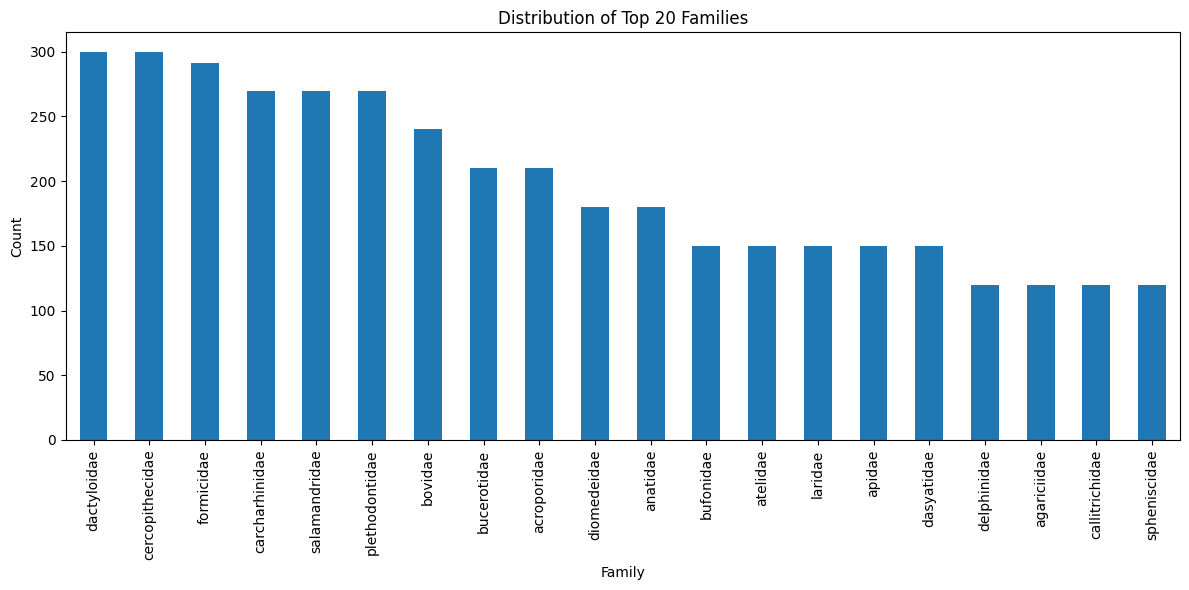

In [ ]:
# defining processed data directory and raw data_dir
DATA_DIR = '/content/rare_species'
processed_data_path = '/content/processed_data'

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

# image distribution by family
if 'family' in metadata.columns:
    family_counts = metadata['family'].value_counts()
    print(f"Number of unique families: {len(family_counts)}")
    print("Top 10 most common families:")
    print(family_counts.head(10))

    # family distribution plot
    plt.figure(figsize=(12, 6))
    family_counts.head(20).plot(kind='bar')
    plt.title('Distribution of Top 20 Families')
    plt.xlabel('Family')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


The bar chart shows the 20 most frequent families, where Dactyloidae, Cercopithecidae, and Formicidae appears as the dominant families with over 290 image each. As we have 11983 images, and half of them are distributed over 3 families, this means that we have a class imbalance.

Number of unique phylums: 5
phylum distribution:
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64


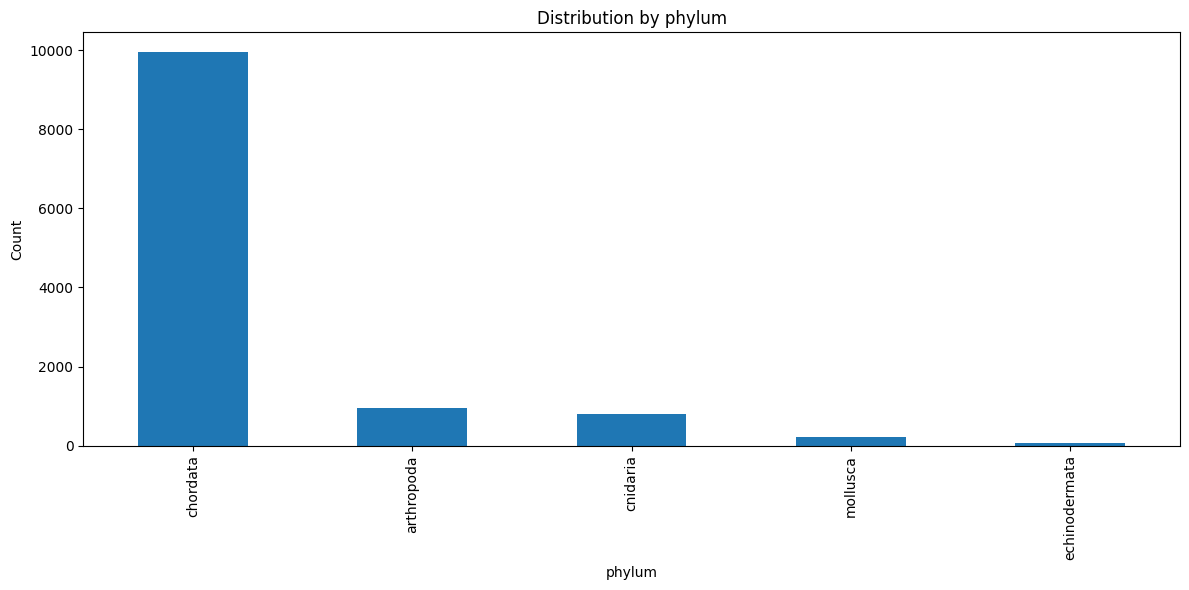

In [ ]:
# now we check image distribution by phylum
if 'phylum' in metadata.columns:
    phylum_counts = metadata['phylum'].value_counts()
    print(f"Number of unique phylums: {len(phylum_counts)}")
    print("phylum distribution:")
    print(phylum_counts.head())

    # phylum distribution plot
    plt.figure(figsize=(12, 6))
    phylum_counts.plot(kind='bar')
    plt.title('Distribution by phylum')
    plt.xlabel('phylum')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

This bar chart shows that chrodata is the dominant phylum type of the 5 classes, while Echinodermata is close to 0. If we further want to use phylum as an output, we might need to consider balancing the classes.

Total number of images : 11983
Total number of families :
phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
dtype: int64


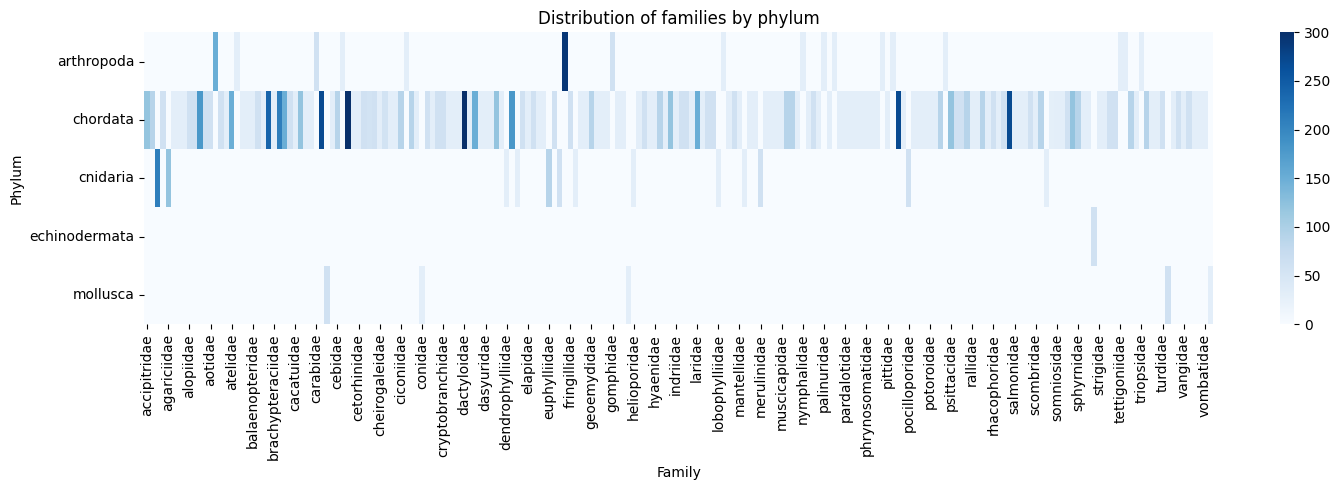

In [ ]:
# Make a table to see how families are spread across each phylum
pivot_table = pd.pivot_table(metadata,
                             index='phylum',
                             columns='family',
                             aggfunc='size',
                             fill_value=0)

print(f"Total number of images : {pivot_table.values.sum()}")
print("Total number of families :")
print(pivot_table.astype(bool).sum(axis=1))  # Counts how many families each phylum has

# Show a heatmap of the distribution
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='Blues', annot=False)
plt.title('Distribution of families by phylum')
plt.xlabel('Family')
plt.ylabel('Phylum')
plt.tight_layout()
plt.show()

The heatmap shows the distribution of families across the different phylum types, where the chordata appears to hold most families as expected from the previous chart.

##Image Quality and Resolution check

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Image Resolution Analysis:
Unique resolutions: 5229
Average width: 1924.6 ± 1267.5
Average height: 1512.3 ± 951.3

Format distribution:
JPEG    11983
Name: count, dtype: int64


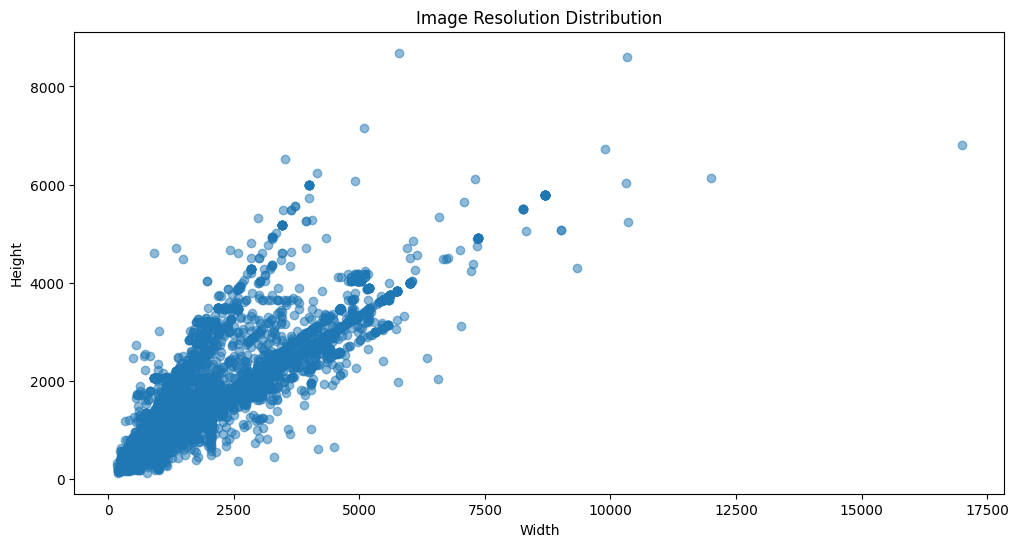

In [ ]:
if 'file_path' in metadata.columns:
    # Analyze image dimensions
    resolutions = []
    formats = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        try:
            with Image.open(img_path) as img:
                resolutions.append(img.size)
                formats.append(img.format)
        except:
            continue

    # Calculate statistics
    unique_resolutions = pd.Series(resolutions).value_counts()
    width, height = zip(*resolutions)

    print("\nImage Resolution Analysis:")
    print(f"Unique resolutions: {len(unique_resolutions)}")
    print(f"Average width: {np.mean(width):.1f} ± {np.std(width):.1f}")
    print(f"Average height: {np.mean(height):.1f} ± {np.std(height):.1f}")
    print("\nFormat distribution:")
    print(pd.Series(formats).value_counts())

    # Visualize resolution distribution
    plt.figure(figsize=(12, 6))
    plt.scatter(width, height, alpha=0.5)
    plt.title('Image Resolution Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

Most of the images are on the smaller side—less than 5000 pixels wide and 3000 pixels tall. A few images are much bigger, with some as wide as 17,500 pixels. In general, wider images also tend to be taller, which makes sense. There seem to be a few different groups of image sizes, which might mean they came from different sources or were taken in different ways.

##Color Distribution Across Species

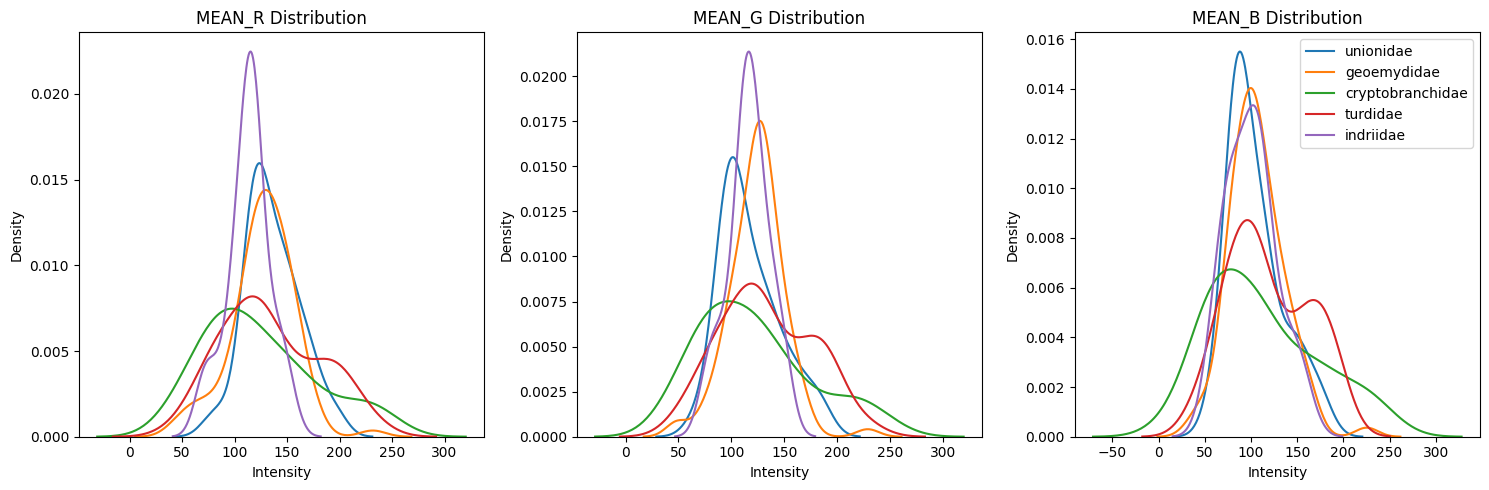

In [ ]:
if 'family' in metadata.columns:
    # Calculate color statistics
    color_stats = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            color_stats.append({
                'family': row['family'],
                'mean_r': np.mean(img[:,:,0]),
                'mean_g': np.mean(img[:,:,1]),
                'mean_b': np.mean(img[:,:,2])
            })
        except:
            continue

    color_df = pd.DataFrame(color_stats)

    # color distributionp plot for the 5 most frequent families
    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(['mean_r', 'mean_g', 'mean_b']):
        plt.subplot(1, 3, i+1)
        for family in color_df['family'].unique()[:5]:
            sns.kdeplot(color_df[color_df['family'] == family][channel], label=family)
        plt.title(f'{channel.upper()} Distribution')
        plt.xlabel('Intensity')
    plt.tight_layout()
    plt.legend()
    plt.show()

The three density plots represent the distributions of red, green, and blue channel intensities across the five most frequent families. Most families show peak intensity values between 100 and 150. However, we can notice a few differences, ex:
- Indriidae shows a sharp and narrow peak in all three channels density, which reflects consistent coloration across its images.
- Cryptobranchidae has broader distributions with higher intensities, especially in the red and green channels, which reflects more color variation or brighter images.

We suppose that these variations in density and intensity are due to differences in the animals' natural coloration, their environments, or how the images were captured (e.g., lighting, cameras, etc.).
This color imbalance suggests the usage of augmentation so that the model could learn equitably.


##Shape & Texture features

In [ ]:
plt.figure(figsize=(15, 10))
for i, (idx, row) in enumerate(metadata.iterrows(), 1):  # iterate through ALL rows, might take around 40mins to run
    img_path = os.path.join(DATA_DIR, row['file_path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(len(metadata), 2, i*2-1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original: {row["family"]}')

# edge detection

    edges = cv2.Canny(img, 100, 200)
    plt.subplot(len(metadata), 2, i*2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')

plt.tight_layout()
plt.show()

# texture analysis

texture_features = []
for idx, row in metadata.iterrows():
    img_path = os.path.join(DATA_DIR, row['file_path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        texture_features.append({
            'family': row['family'],
            'contrast': feature.greycoprops(feature.greycomatrix(img, [1], [0]), 'contrast')[0][0],
            'entropy': shannon_entropy(img)
        })

texture_df = pd.DataFrame(texture_features)

# texture features plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='contrast', data=texture_df[texture_df['family'].isin(texture_df['family'].value_counts().index[:5])])
plt.title('Texture Contrast Distribution by Family')
plt.xticks(rotation=45)
plt.show()

For texture anaysis and shape features of the images, we applied Edge Detection and Texture Extraction using a technique called Local Binary Patterns (LBP):

- Starting with the shape, we percieve clear and distinguishable outlines in most of our image shapes, and which reflects the presence of a few images with complex or Noisy backgrounds.
- The texture of the images is variate, as the shells image show a consistent texture pattern, while other images have more "sparse" texture details.

# Prepare Data

In [17]:
#general configurations
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# we define the mean and the std deviation for RGB
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

In [18]:
# we define a function to eliminate low quality images
def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]


In [19]:
# analisar familias com menos imagens
def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

In [20]:
#prepare the dataset
def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


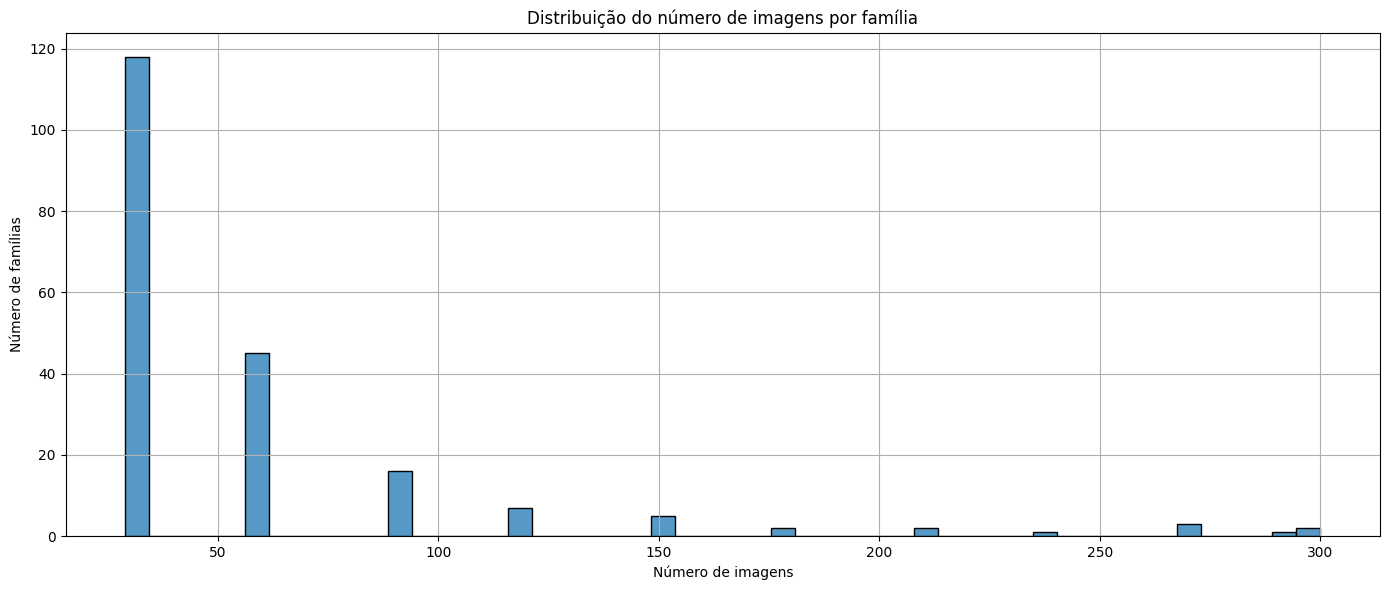

Famílias com menos de 10 imagens:
Series([], Name: count, dtype: int64)
✅ Dados carregados e prontos


In [21]:
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)
NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

#Models

We start by defining the models that we want to test

In [22]:
# pretrained models
def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", NUM_PHYLA, NUM_FAMILIES)

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", NUM_PHYLA, NUM_FAMILIES)

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", NUM_PHYLA, NUM_FAMILIES)


In [23]:
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")


# check one models' performance at a time

In [ ]:
#model = VGG16_Model  # Ou outro modelo que deseje testar
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-3),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy"]
#)

#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=20,
#    callbacks=[
#        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#    ]
#)

In [ ]:
#plt.plot(history.history['accuracy'], label='train acc')
#plt.plot(history.history['val_accuracy'], label='val acc')
#plt.legend()
#plt.title("Accuracy per epoch")
#plt.show()

In [ ]:
#model = model_efficient  # Ou outro modelo que deseje testar
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-3),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy"]
#)

#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=20,
#    callbacks=[
#        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#    ]
#)

In [ ]:
#plt.plot(history.history['accuracy'], label='train acc')
#plt.plot(history.history['val_accuracy'], label='val acc')
#plt.legend()
#plt.title("Accuracy per epoch")
#plt.show()

In [ ]:
#model = model_resnet  # Ou outro modelo que deseje testar
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-3),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy"]
#)

#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=20,
#    callbacks=[
#        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#    ]
#)

In [ ]:
#plt.plot(history.history['accuracy'], label='train acc')
#plt.plot(history.history['val_accuracy'], label='val acc')
#plt.legend()
#plt.title("Accuracy per epoch")
#plt.show()

#Run all models in a loop

In [25]:
def get_predictions_and_labels(model, val_ds):
    y_true = []
    y_pred_probs = []

    # from val data
    for (img, phylum), label in val_ds.unbatch():
        # calculate the prediction
        pred = model.predict([img[None, ...], phylum[None, ...]], verbose=0)
        y_pred_probs.append(pred[0])  # Probability for each class
        y_true.append(label.numpy())  # real label

    return np.array(y_true), np.array(y_pred_probs)

In [26]:

def plot_roc_auc(y_true, y_pred_probs, num_classes, model_name):
    # we binarize labels for the auc curve (false positives and true positives)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # create dictionnaires for false positive true positive and the roc auc curve
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calcule ROC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate the average macro AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    mean_auc = auc(all_fpr, mean_tpr)

    # AUC ROC plot
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {mean_auc:.2f})', linestyle='--')
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', alpha=0.3)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve pour {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return mean_auc

In [27]:
#F1 score definition
def compute_f1_score(y_true, y_pred_probs):
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

In [ ]:
# list of the models to try
models = [
    model_vgg16,
    model_resnet,
    model_efficient,
    build_custom_cnn(NUM_PHYLA, NUM_FAMILIES)
]

# stock results
results = {}

# loop to train each model
for model in models:
    print(f"\nEntraînement du modèle : {model.name}\n")

    # compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        ]
    )

    # stock train results
    results[model.name] = history.history

    # accuracy plot
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title(f"Accuracy pour {model.name}")
    plt.show()

    # calculate labels and predictions for auc roc
    y_true, y_pred_probs = get_predictions_and_labels(model, val_ds)

    # calculate and show auc roc
    mean_auc = plot_roc_auc(y_true, y_pred_probs, NUM_FAMILIES, model.name)
    print(f"AUC (macro-average) pour {model.name} : {mean_auc:.2f}")

    # calculate and show F1 Score
    f1 = compute_f1_score(y_true, y_pred_probs)
    print(f"F1 Score (weighted) pour {model.name} : {f1:.2f}")


Entraînement du modèle : VGG16_Model

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 257s 388ms/step - accuracy: 0.0482 - loss: 5.0017 - val_accuracy: 0.1736 - val_loss: 3.8727
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 279s 434ms/step - accuracy: 0.1547 - loss: 3.8654 - val_accuracy: 0.2065 - val_loss: 3.3662
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 279s 435ms/step - accuracy: 0.2013 - loss: 3.4476 - val_accuracy: 0.2545 - val_loss: 3.0929
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 324s 499ms/step - accuracy: 0.2281 - loss: 3.2295 - val_accuracy: 0.2887 - val_loss: 2.9164
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 359s 468ms/step - accuracy: 0.2569 - loss: 3.0290 - val_accuracy: 0.3271 - val_loss: 2.7667
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 259s 401ms/step - accuracy: 0.2827 - loss: 2.8802 - val_accuracy: 0.3237 - val_loss: 2.6804
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 304s 455ms/step - accuracy: 0.3053 - loss: 2.7570 - val_accuracy: 0.3517 - val_loss: 2.6074
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━